# Проведение A/B-тестирования

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm.auto import tqdm
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных и их анализ

1. Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [2]:
url_1 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ'

In [3]:
groups_first = pd.read_csv('groups.csv', sep=';')

2. Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [4]:
url_2 = 'https://getfile.dokpub.com '

In [5]:
groups_add = pd.read_csv('group_add.csv')

3. Файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [6]:
url_3 = 'https://getfile.dokpub.com '

In [7]:
checks = pd.read_csv('checks.csv', sep=';')

4. Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [8]:
url_3 = 'https://getfile.dokpub.com '

In [9]:
active_studs = pd.read_csv('active_studs.csv')

### Изучим данные

#### Groups

In [10]:
groups_first.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [11]:
groups_first.shape

(74484, 2)

In [12]:
groups_first.dtypes

id      int64
grp    object
dtype: object

In [13]:
groups_first.nunique()

id     74484
grp        2
dtype: int64

In [14]:
groups_first.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [15]:
groups_first.isna().sum()

id     0
grp    0
dtype: int64

In [16]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [17]:
groups_add.shape

(92, 2)

In [18]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [19]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [20]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [21]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [22]:
# объединим два датафрейма для удобства дальнейшей работы
groups = pd.concat([groups_first, groups_add])

In [23]:
groups.shape

(74576, 2)

In [24]:
groups.nunique()

id     74576
grp        2
dtype: int64

Дублирующихся значений в объединенном датафрейме нет. В обоих датафреймах отсутствуют пропущенные значения.

#### Active_studs

In [25]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [26]:
active_studs.shape

(8341, 1)

In [27]:
active_studs.dtypes

student_id    int64
dtype: object

In [28]:
active_studs.nunique()

student_id    8341
dtype: int64

In [29]:
active_studs.isna().sum()

student_id    0
dtype: int64

Дубликатов и нулевых значений в файле нет

#### Checks

In [30]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [31]:
checks.shape

(541, 2)

In [32]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [33]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [34]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Дубликатов и нулевых значений в файле нет.

## Создание объединенного датафрейма

Создадим единый датафрейм со всей необходимой информацией.

1. Добавим колонку с информацией был ли активен студент в период эксперимента (1 - активен, 0 - не активен)

In [35]:
active_studs['active'] = 1

2. Объединим датафреймы и приведем колонки "active" и "rev" к нужному виду

In [36]:
full = groups.merge(active_studs, how='left', left_on='id', right_on='student_id')

In [37]:
full = full.merge(checks, how='left', left_on='id', right_on='student_id')

In [38]:
full.drop(labels=['student_id_x', 'student_id_y'], axis=1, inplace=True)

In [39]:
full.active = full.active.fillna(0)
full.active = full.active.astype('int')
full.rev = full.rev.fillna(0)

In [40]:
full.head()

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [41]:
full.shape

(74576, 4)

3. Изучим как пользователи распределены по группам

[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Группа')]

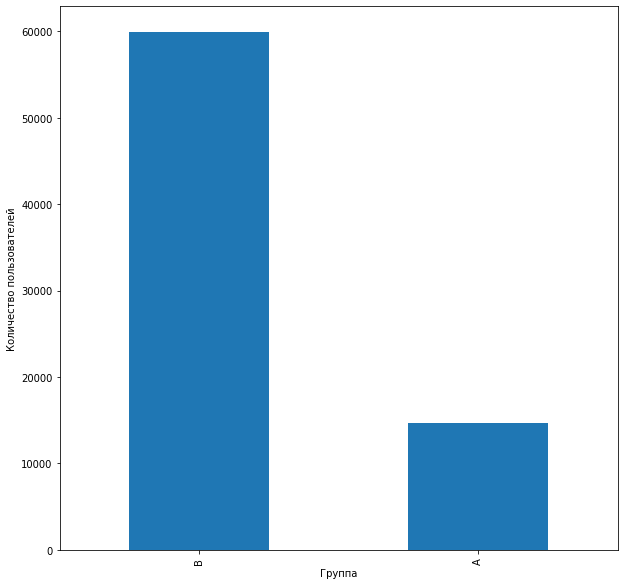

In [42]:
plt.figure(figsize=(10,10))
test_groups = full.grp.value_counts().plot(kind='bar')
test_groups.set(xlabel="Группа", ylabel="Количество пользователей")

In [43]:
groups.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Количество пользователей в целевой группе примерно в 4 раза превышает количество пользователей в тестовой группе. Предполагаю, что разбиение на группы произошло некорректно, поэтому нужно выяснить в чем причина. 

[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Активность')]

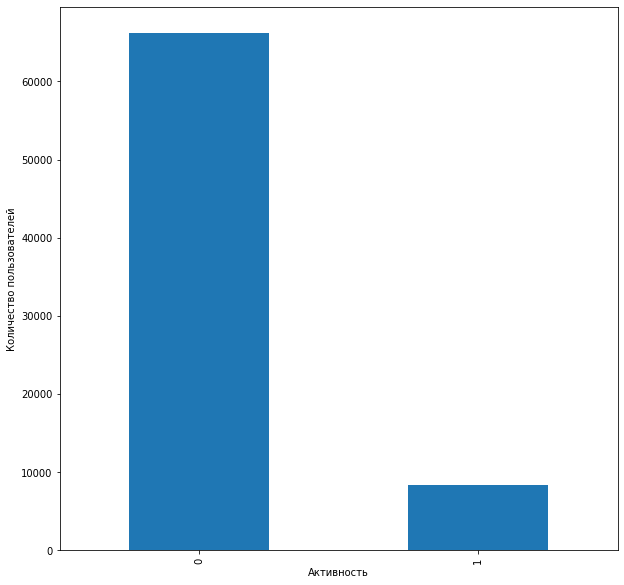

In [44]:
plt.figure(figsize=(10,10))
act_groups = full.active.value_counts().plot(kind='bar')
act_groups.set(xlabel="Активность", ylabel="Количество пользователей")

In [45]:
full.active.value_counts()

0    66235
1     8341
Name: active, dtype: int64

In [46]:
full[full['grp'] == 'A'].active.value_counts()

0    13155
1     1538
Name: active, dtype: int64

In [47]:
full[full['grp'] == 'B'].active.value_counts()

0    53080
1     6803
Name: active, dtype: int64

In [48]:
full[full.rev > 0].grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

[Text(0, 0.5, 'Группа'), Text(0.5, 0, 'Сумма оплаты')]

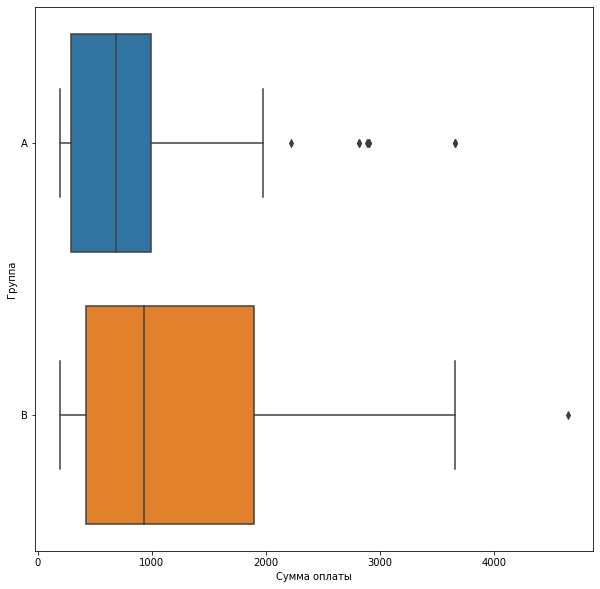

In [49]:
plt.figure(figsize=(10,10))
pay_users = sns.boxplot(data=full[full.rev > 0], x="rev", y="grp")
pay_users.set(xlabel="Сумма оплаты", ylabel="Группа")

[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Сумма оплаты')]

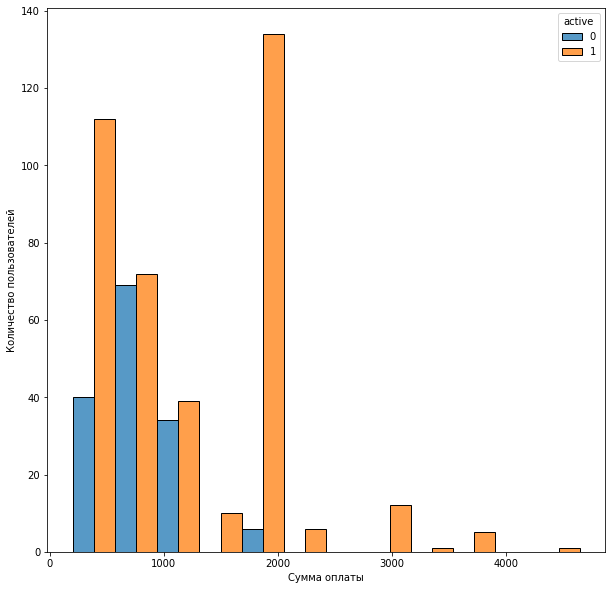

In [50]:
plt.figure(figsize=(10,10))
active_pay_users = sns.histplot(full[full.rev > 0], x='rev', hue='active', multiple="dodge")
active_pay_users.set(xlabel="Сумма оплаты", ylabel="Количество пользователей")

[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Сумма оплаты')]

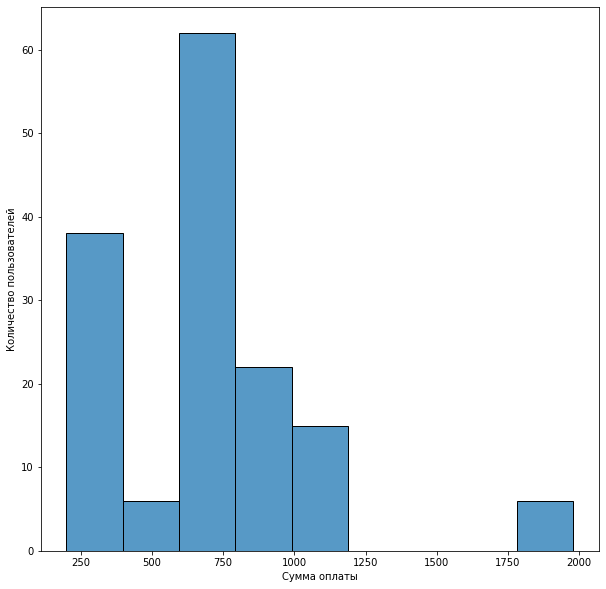

In [51]:
plt.figure(figsize=(10,10))
inactive_pay_users = sns.histplot(full[(full.active == 0) & (full.rev > 0)], x='rev')
inactive_pay_users.set(xlabel="Сумма оплаты", ylabel="Количество пользователей")

In [52]:
full[(full.active == 0) & (full.rev > 0)].shape

(149, 4)

In [53]:
full.drop(index=full[(full.active == 0) & (full.rev > 0)].index, inplace=True)

**Выводы:** 

- всего записей - 74 576. Из них в контрольной группе - 14 693 пользователей, в тестовой группе - 59 883 пользователей
- в контрольной группе 13 126 неактивных пользователей и 1 538 активных
- в целевой группе 52 960 неактивных пользователей и 6 803 активных
- покупку совершили 541 пользователя (314 в целевой группе и 78 в тестовой)
- в ходе анализа были найдены 149 пользователей, которые были не активны в период проведения эксперимента, но что-то оплачивали. Необходимо выяснить причину появления этих записей. В дальнейший анализ их включать не стоит
- также в данных мы видим неравномерное распределение на целевую и контрольную группы, стоит выяснить почему так произошло 

## Метрики и проведение тестов

### Метрика 1: Конверсия посетителя сайта в покупателя

Считаю, что на конверсию в покупку в данном эксперименте стоит опираться в первую очередь. Изменение механики оплаты может повлиять именно на то, принял ли решение пользователь оплачивать курс на сайте или нет.

**Нулевая гипотеза: Количество пользователей совершивших покупку в контрольной и тестовой группе одинаковое**

**Альтернативная гипотеза: Количество пользователей совершивших покупку в контрольной и тестовой группе различается**

Составим таблицу сопряженности и применим критерий Хи-квадрат

In [54]:
full.head()

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [55]:
active_users = full[full['active']==1]

In [56]:
active_users['bought'] = list(map(lambda x: 'bought' if x > 0 else 'not_bought', active_users.rev))

In [57]:
pivot_table = active_users.groupby(['grp', 'bought'], as_index=False) \
    .agg({'id': 'count'}) \
    .pivot(index='grp', values='id', columns='bought')

In [58]:
pivot_table

bought,bought,not_bought
grp,,
A,78,1460
B,314,6489


In [59]:
cr_groop_A = round((active_users[(active_users['grp'] == 'A') & (active_users['bought'] == 'bought')].id.count() \
            / active_users[active_users['grp'] == 'A'].id.count())*100, 2)

In [60]:
cr_groop_B = round((active_users[(active_users['grp'] == 'B') & (active_users['bought'] == 'bought')].id.count() \
            / active_users[active_users['grp'] == 'B'].id.count())*100, 2)

In [61]:
print('Коверсия в контрольной группе {}'.format(cr_groop_A))
print('Коверсия в тестовой группе {}'.format(cr_groop_B))

Коверсия в контрольной группе 5.07
Коверсия в тестовой группе 4.62


In [62]:
scipy.stats.chi2_contingency(pivot_table)

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[  72.28102146, 1465.71897854],
        [ 319.71897854, 6483.28102146]]))

**Вывод:** поскольку значение p-value больше 0,05 мы не можем отвергнуть нулевую гипотезу. Соответственно, сделать вывод, оплачивают ли пользователи из тестовой группы покупки чаще, мы тоже не можем

### Метрика 2: ARPPU

Можем также посмотреть как изменилась средняя сумма выручки на каждого платящего пользователя с изменением механики оплаты.

**Нулевая гипотеза: величина ARPPU с изменением механики оплаты не изменилась**

**Альтернативная гипотеза: изменение механики оплаты повлияло на изменение ARPPU**


In [63]:
full.head()

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [64]:
group_A = full[(full['grp'] == 'A') & (full['rev'] > 0)]

In [65]:
group_A.head(3)

,id,grp,active,rev
1,1627,A,1,990.0
4625,287008,A,1,1830.0
6328,332387,A,1,2910.0


In [66]:
group_B = full[(full['grp'] == 'B') & (full['rev'] > 0)]

In [67]:
group_B.head(3)

,id,grp,active,rev
220,100300,B,1,990.0000
320,108270,B,1,290.0000
3779,264473,B,1,1900.0001


In [68]:
ARPPU_control = group_A.rev.sum() / group_A.id.count()

In [69]:
ARPPU_test = group_B.rev.sum() / group_B.id.count()

In [70]:
print('ARPPU в контрольной группе {}'.format(round(ARPPU_control, 2)))

ARPPU в контрольной группе 933.59


In [71]:
print('ARPPU в тестовой группе {}'.format(round(ARPPU_test, 2)))

ARPPU в тестовой группе 1257.88


In [72]:
# размер контрольной группы
group_A.id.count()

78

In [73]:
# размер тестовой группы
group_B.id.count()

314

In [74]:
scipy.stats.normaltest(group_A.rev)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [75]:
scipy.stats.normaltest(group_B.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Оба распределения нормальными не являются, а также присутствует довольно большия разница между размерами групп. Поэтому в данном случае лучше применить bootstrap

In [76]:
# Объявим функцию, которая позволит проверять гипотезы с помощью bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

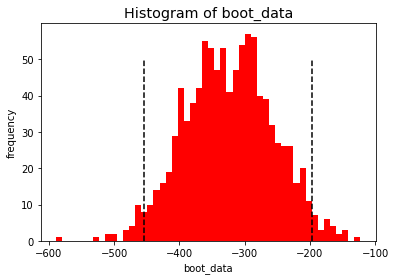

In [77]:
arppu_bootstrap = get_bootstrap(group_A.rev, group_B.rev)

In [78]:
arppu_bootstrap['p_value']

1.6048242866602976e-06

**Вывод:** так как p-value меньше 0.05 мы можем отвергнуть нулевую гипотезу, а это значит что различия между средними в контрольной и тестовой группе статистически значимы. 
Однако, вызывает вопросы разбиение на контрольную и тестовую группы и наличие в данных записей, которые мы не можем объяснить без дополнительной информации. Кроме того, анализ метрик не дает нам однозначного ответа, влияетли новая механика оплат положительно на опыт пользователей. 

На мой взгляд, 
1. Нужно прояснить что произошло с данными; 
2. Нужно детальнее изучить процесс оплаты на сайте и выяснить на каком именно пользователи уходят и почему